In [2]:
%matplotlib inline
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

import numpy as np

from sky_spot.traces import random_start
from plot import *

sns.set_style('whitegrid')
InitMatplotlib(7, 7)
# RAW_PATH = '../../data/real/availability/2023-02-15/parsed'
RAW_PATH = '../../data/real/ping_based_complete'

LENGTH_HOURS = list(range(1, 80))

use_tex True 
font_size 7 
title_size 7


In [3]:
df = pd.DataFrame(columns=[
    'file',
    'length_hours',
    'spot_fraction',
    'avg_spot_fraction',
    'variance',
])
for length_hours in LENGTH_HOURS:
    for file in os.listdir(RAW_PATH):
        if not file.endswith('.json'):
            continue
        raw_path = os.path.join(RAW_PATH, file)
        output_dir = os.path.join(raw_path.replace('data', 'exp'), f'length={length_hours}h')
        os.makedirs(output_dir, exist_ok=True)
        random_start.generate_random_traces(
            raw_path,
            num_traces=300,
            trace_length_hours=length_hours,
            output_dir=output_dir,
        )
        spot_fraction = []
        for trace in os.listdir(output_dir):
            if not trace.endswith('.json'):
                continue
            trace_path = os.path.join(output_dir, trace)
            with open(trace_path, 'r') as f:
                data = json.load(f)['data']
            availability = 1 - np.array(data)
            spot_fraction.append(np.mean(availability))
            

        df = df.append({
            'file': file,
            'length_hours': length_hours,
            'spot_fraction': spot_fraction,
            'avg_spot_fraction': np.mean(spot_fraction),
            'variance': np.var(spot_fraction),
        }, ignore_index=True)
df.to_csv('../../results/real/trace_property.csv', index=False)

/tmp/ipykernel_19444/1000382918.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_19444/1000382918.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_19444/1000382918.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_19444/1000382918.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_19444/1000382918.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/tmp/ipykernel_19444/1000382918.py:32: Future

## Spot fraction

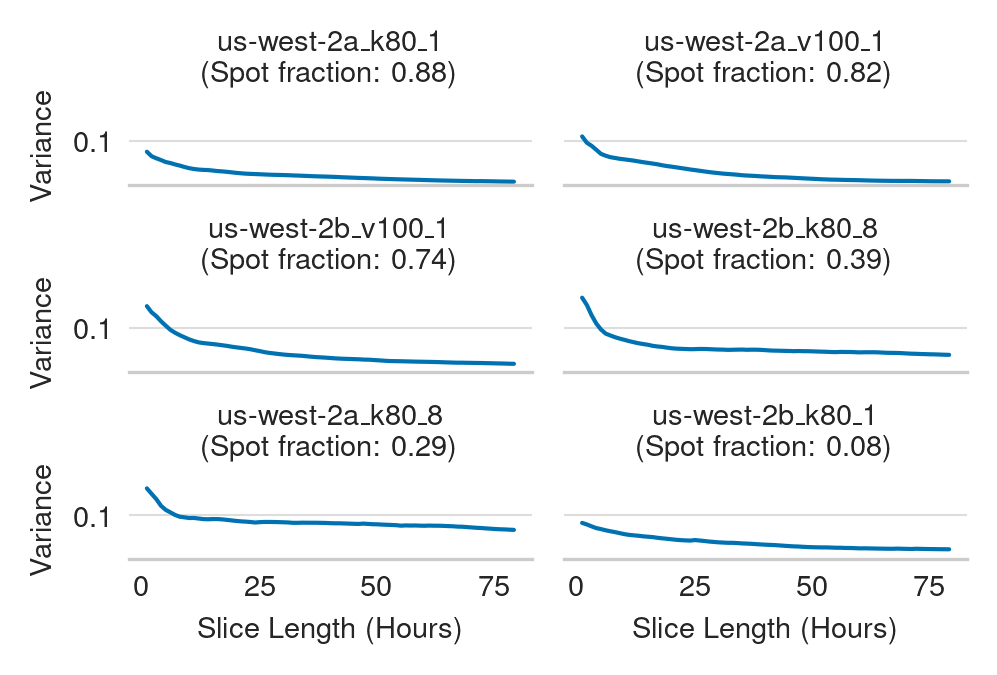

In [13]:
df.sort_values(by='avg_spot_fraction', inplace=True, ascending=False)
env_paths = [
    'us-west-2a_k80_1',
    'us-west-2a_v100_1',
    'us-west-2b_v100_1',
    'us-west-2b_k80_8',
    'us-west-2a_k80_8',
    # 'us-west-2b_v100_8',
    # 'us-west-2a_v100_8',
    'us-west-2b_k80_1',
]
# env_paths = df.file.unique()

fig = plt.figure(figsize=(fig_width, fig_height + .2), dpi=300)
axes = fig.subplots(len(env_paths) // 2, 2, sharex=True, sharey=True)
for i, env_path in enumerate(env_paths):
    ax = axes[i // 2, i % 2]
    env_df = df[df['file'].str.contains(env_path)]

    spot_fraction = env_df['avg_spot_fraction'].mean()
    sns.lineplot(
        x=env_df['length_hours'],
        y=env_df['variance'],
        ax=ax,
    )
    ax.set_title(f'{env_path.replace(".json", "")}'
                 f'\n(Spot fraction: {spot_fraction:.2f})'
                )
    ax.set_xlabel('Slice Length (Hours)')
    ax.set_ylabel('Variance')
    ax.set_yticks([0.1])

fig.tight_layout()
fig.savefig('figures/variance.pdf', bbox_inches='tight')

## Daily avg spot time

In [13]:
RAW_PATH = '../../data/real/availability/2023-02-15/parsed'
time_df = pd.DataFrame(columns=[
    'file',
    'spot_time',
    'wait_time',
])
def get_spot_wait_time(day_trace):
    padded = np.array([0] + list(day_trace) + [0])
    delta = padded[1:] - padded[:-1]
    lengths = np.where(delta == -1)[0] - np.where(delta == 1)[0]
    lengths = lengths * gap_seconds / 3600
    spot_time = np.mean(lengths)

    padded = np.array([0] + list(1 - day_trace) + [0])
    delta = padded[1:] - padded[:-1]
    lengths = np.where(delta == -1)[0] - np.where(delta == 1)[0]
    lengths = lengths * gap_seconds / 3600
    wait_time = np.mean(lengths)
    return spot_time, wait_time

for file in os.listdir(RAW_PATH):
    if not file.endswith('.json'):
        continue
    raw_path = os.path.join(RAW_PATH, file)
    with open(raw_path, 'r') as f:
        data = json.load(f)

    gap_seconds = data['metadata']['gap_seconds']
    day_gaps = int(24 * 3600 / gap_seconds)

    availability = 1 - np.array(data['data'])
    availability = availability[:len(availability) // day_gaps * day_gaps]

    daily_avail = availability.reshape(-1, int(24 * 3600 / gap_seconds))
    spot_time_daily = []
    wait_time_daily = []
    for day in daily_avail:
        spot_time, wait_time = get_spot_wait_time(day)
        spot_time_daily.append(spot_time)
        wait_time_daily.append(wait_time)

    time_df = time_df.append({
        'file': file,
        'spot_time': spot_time_daily,
        'wait_time': wait_time_daily,
    }, ignore_index=True)

time_df.to_csv('../../results/real/spot_wait_time.csv', index=False)


/opt/conda/envs/sky-spot/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/sky-spot/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_11012/3145508139.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  time_df = time_df.append({
/opt/conda/envs/sky-spot/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/sky-spot/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_11012/3145508139.py:42: FutureWarning: The frame.append method is deprecated and wil

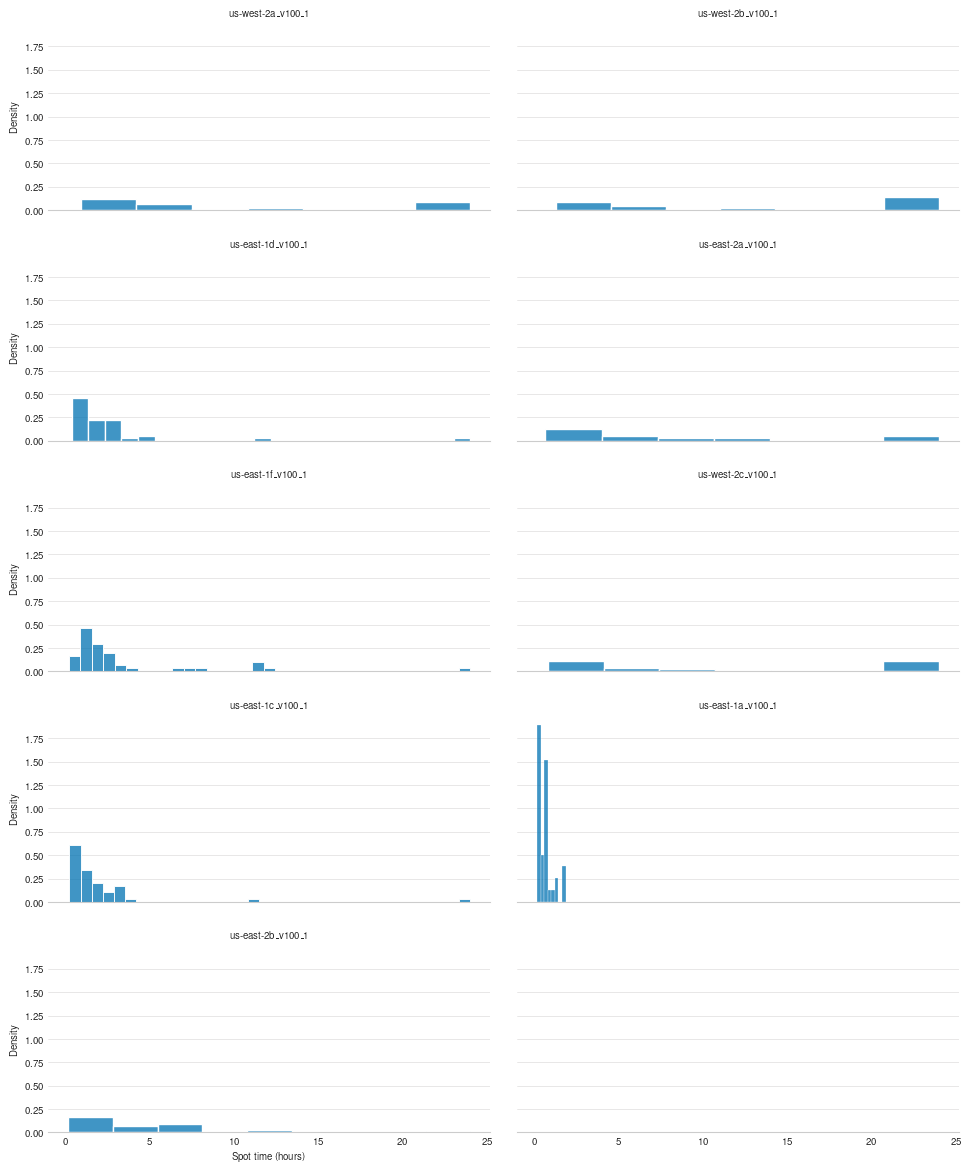

In [14]:
plt.rcParams['font.size'] = 16
# env_paths = [
#     'us-west-2a_k80_1', 'us-west-2a_v100_1', 'us-west-2b_v100_1',
#     'us-west-2b_k80_1'
# ]

env_paths = time_df['file'].unique()

fig = plt.figure(figsize=(10, 12))
axes = fig.subplots((len(env_paths)+1) // 2, 2, sharex=True, sharey=True)
for i, env_path in enumerate(env_paths):
    ax = axes[i // 2, i % 2]
    env_df = time_df[time_df['file'].str.contains(env_path)]

    sns.histplot(data=env_df['spot_time'].values[0], ax=ax, stat='density')
    ax.set_title(f'{env_path.replace(".json", "")}')
    ax.set_xlabel('Spot time (hours)')
    ax.set_ylabel('Density')

fig.tight_layout()

## Daily avg spot time (random selection)

/tmp/ipykernel_11012/3306393038.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  time_df = time_df.append({
/opt/conda/envs/sky-spot/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/sky-spot/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_11012/3306393038.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  time_df = time_df.append({
/tmp/ipykernel_11012/3306393038.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  time_df = time_df.append({
/tmp/ipykernel_11012/3306393038.py:51: FutureWa

Text(0.5, 1.05, '1-day avg wait time')

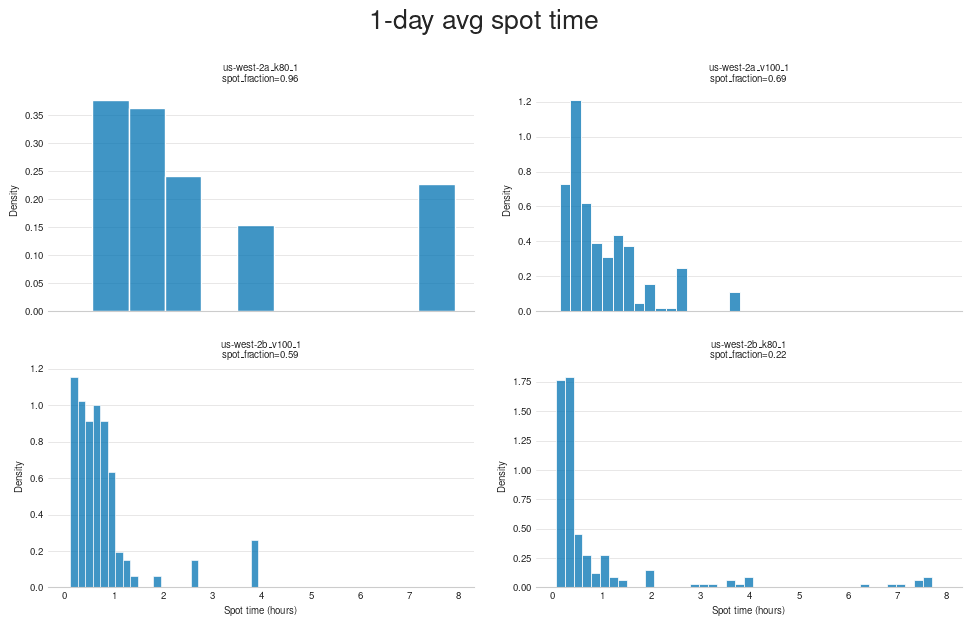

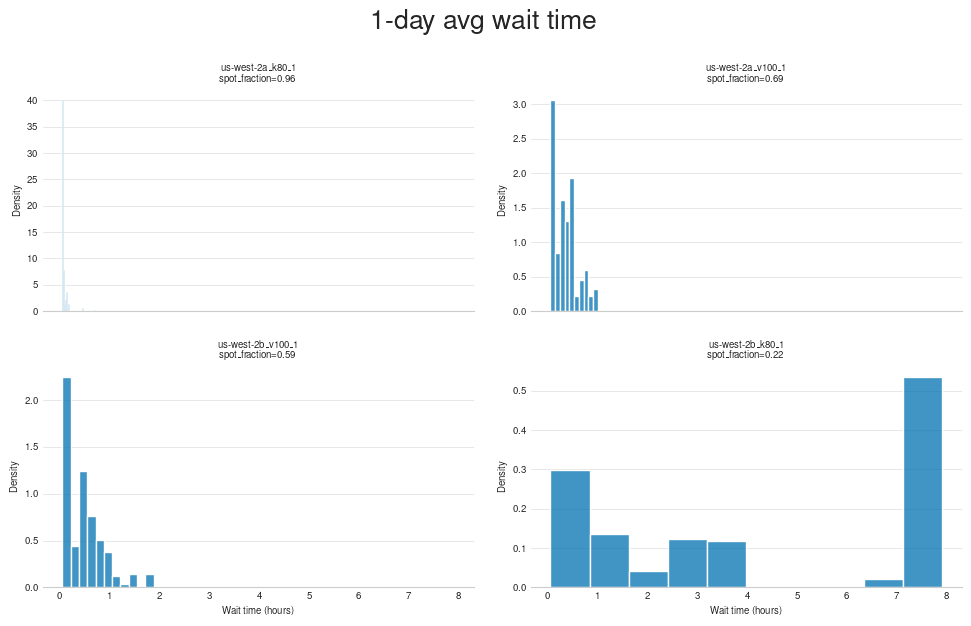

In [15]:
# RAW_PATH = '../../data/real/availability/2023-02-15/parsed'
RAW_PATH = '../../data/real/ping_based'
time_df = pd.DataFrame(columns=[
    'file',
    'spot_time',
    'wait_time',
])
def get_spot_wait_time(day_trace):
    padded = np.array([0] + list(day_trace) + [0])
    delta = padded[1:] - padded[:-1]
    lengths = np.where(delta == -1)[0] - np.where(delta == 1)[0]
    lengths = lengths * gap_seconds / 3600
    spot_time = np.mean(lengths)

    padded = np.array([0] + list(1 - day_trace) + [0])
    delta = padded[1:] - padded[:-1]
    lengths = np.where(delta == -1)[0] - np.where(delta == 1)[0]
    lengths = lengths * gap_seconds / 3600
    wait_time = np.mean(lengths)
    return spot_time, wait_time

length = 24
for file in os.listdir(RAW_PATH):
    if not file.endswith('.json'):
        continue
    raw_path = os.path.join(RAW_PATH, file)
    output_dir = os.path.join(raw_path.replace('data', 'exp'), f'length={length}h')
    os.makedirs(output_dir, exist_ok=True)
    random_start.generate_random_traces(
        raw_path,
        num_traces=300,
        trace_length_hours=length,
        output_dir=output_dir,
    )

    spot_time_daily = []
    wait_time_daily = []
    spot_fraction = []
    for trace in os.listdir(output_dir):
        if not trace.endswith('.json'):
            continue
        trace_path = os.path.join(output_dir, trace)
        with open(trace_path, 'r') as f:
            data = json.load(f)['data']
        availability = 1 - np.array(data)
        spot_time, wait_time = get_spot_wait_time(availability)
        spot_time_daily.append(spot_time)
        wait_time_daily.append(wait_time)
        spot_fraction.append(np.mean(availability))

    time_df = time_df.append({
        'file': file,
        'spot_time': spot_time_daily,
        'wait_time': wait_time_daily,
        'spot_fraction': np.mean(spot_fraction),
    }, ignore_index=True)


plt.rcParams['font.size'] = 16
env_paths = [
    'us-west-2a_k80_1', 'us-west-2a_v100_1', 'us-west-2b_v100_1',
    'us-west-2b_k80_1'
]

# env_paths = time_df['file'].unique()

fig = plt.figure(figsize=(10, 6))
axes = fig.subplots((len(env_paths) + 1) // 2, 2, sharex=True)
for i, env_path in enumerate(env_paths):
    ax = axes[i // 2, i % 2]
    env_df = time_df[time_df['file'].str.contains(env_path)]

    sns.histplot(data=env_df['spot_time'].values[0], ax=ax, stat='density')
    ax.set_title(f'{env_path.replace(".json", "")}\nspot_fraction={env_df["spot_fraction"].values[0]:.2f}')
    ax.set_xlabel('Spot time (hours)')
    ax.set_ylabel('Density')

fig.tight_layout()
fig.suptitle(f'{length/24:.0f}-day avg spot time', y=1.05)

fig = plt.figure(figsize=(10, 6))
axes = fig.subplots((len(env_paths) + 1) // 2, 2, sharex=True)
for i, env_path in enumerate(env_paths):
    ax = axes[i // 2, i % 2]
    env_df = time_df[time_df['file'].str.contains(env_path)]

    sns.histplot(data=env_df['wait_time'].values[0], ax=ax, stat='density')
    ax.set_title(
        f'{env_path.replace(".json", "")}\nspot_fraction={env_df["spot_fraction"].values[0]:.2f}'
    )
    ax.set_xlabel('Wait time (hours)')
    ax.set_ylabel('Density')

fig.tight_layout()
fig.suptitle(f'{length/24:.0f}-day avg wait time', y=1.05)
